In [1]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

# Analysing Adamson Dataset (both samples)

Checking for:
1. Do we see inconsistency in the CHANGE in profiles relative to the ACTUAL controls
2. Do we see inconsistency in the CHANGE in profiles relative to the PSEUDO controls
3. How consistent is this behaviour between cases
4. What do we see when we combine the target data from the Adamson paper with the target data from our work
    - Can run outlier analysis across all target sites, then check the spearman correlation in ranking between or some other ranking metric like the nDCG to see that the top rankings identify the same genes, roughly

Notes: Could group controls into groups of three, might reduce the noise in the control group vs the KO genes, which have roughly 4 barcodes associated with each of them

Need to look for ways to integrate the data


In [2]:
import itertools
from scipy import stats
from scipy.stats import multivariate_normal
import pandas as pd
import seaborn as sns
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from skbio.stats.composition import ilr, clr
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from scipy.stats import chi2
from scipy.spatial.distance import jensenshannon

from statsmodels.stats.multitest import multipletests

from src.models.outliers import outlier_detection, logratio_outlier_detection, impute_zero_values
from src.visualization.plots import biplot, screeplot, loadingsplot, psuedocontrolcomparisonplot
from src.config import get_interim_dir, get_hussmann_supplementary_xlsx, HOME_PATH, get_experiment_artifacts, PROFILE_TYPE, PAIRED_SAMPLES, SAMPLE, FILTER_COUNT

In [3]:
aliases = ["K562_SpCas9_target-1_HDR_oBA701_AX227_rep_{}".format(i) for i in range(1, 3)]
print(aliases)

targets = ["Adamson_T1"]
print(targets)

['K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1', 'K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2']
['Adamson_T1']


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_44632/728488348.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  boxplot_data["log10median <= 1"] = boxplot_data.groupby("Outcome").median()["log10Counts"] <= 1


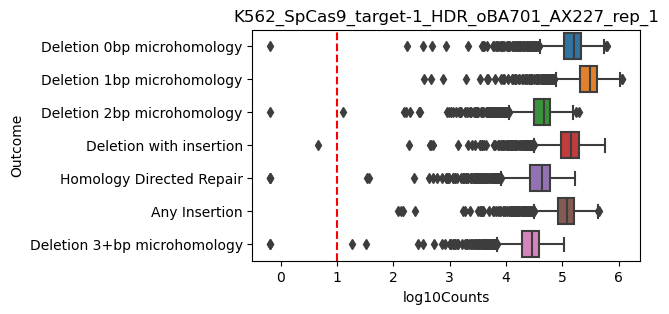

/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_44632/728488348.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  boxplot_data["log10median <= 1"] = boxplot_data.groupby("Outcome").median()["log10Counts"] <= 1


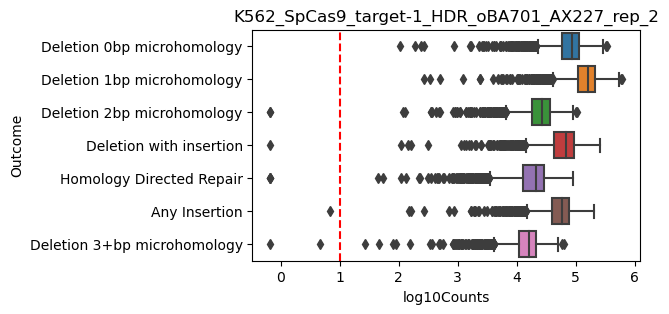

In [4]:
for alias in aliases: 
    X = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_reduced_repair_outcome_profiles.pkl".format(alias))
    X = X + 0.65
    X.columns.name = "Outcome"
    X.head()
    X = X.loc[:, (X != 0).any(axis=0)]
    plt.figure(figsize=(5, 3))
    boxplot_data = np.log10(X.stack()).reset_index().rename(columns={0: "log10Counts"})
    boxplot_data["log10median <= 1"] = boxplot_data.groupby("Outcome").median()["log10Counts"] <= 1
    sns.boxplot(data=boxplot_data, y="Outcome", x="log10Counts")
    plt.axvline(1, ls="--", color="red")
    plt.title(alias)
    plt.show()

In [5]:
X.index.unique("Barcode")

Index(['ACTL6A_-_179280860.23-P1P2', 'ACTL6A___179280744.23-P1P2',
       'ACTL6A___179280849.23-P1P2', 'ACTR5_-_37377127.23-P1P2',
       'ACTR5___37377138.23-P1P2', 'ACTR5___37377152.23-P1P2',
       'ACTR8___53916118.23-P1P2', 'ACTR8___53916142.23-P1P2',
       'ACTR8___53916157.23-P1P2', 'AICDA___8765346.23-P1P2',
       ...
       'YEATS4___69753614.23-P1P2', 'YY1_-_100705185.23-P1P2',
       'YY1___100705579.23-P1P2', 'YY1___100705824.23-P1P2',
       'ZNHIT1_-_100860970.23-P1P2', 'ZNHIT1_-_100861479.23-P1P2',
       'ZNHIT1_-_100861482.23-P1P2', 'ZRANB3_-_136288444.23-P1P2',
       'ZRANB3_-_136288748.23-P1P2', 'ZRANB3___136288107.23-P1P2'],
      dtype='object', name='Barcode', length=1534)

In [6]:
len([g for g in X.index.get_level_values("Gene").to_list() if "non" in g.lower()])

60

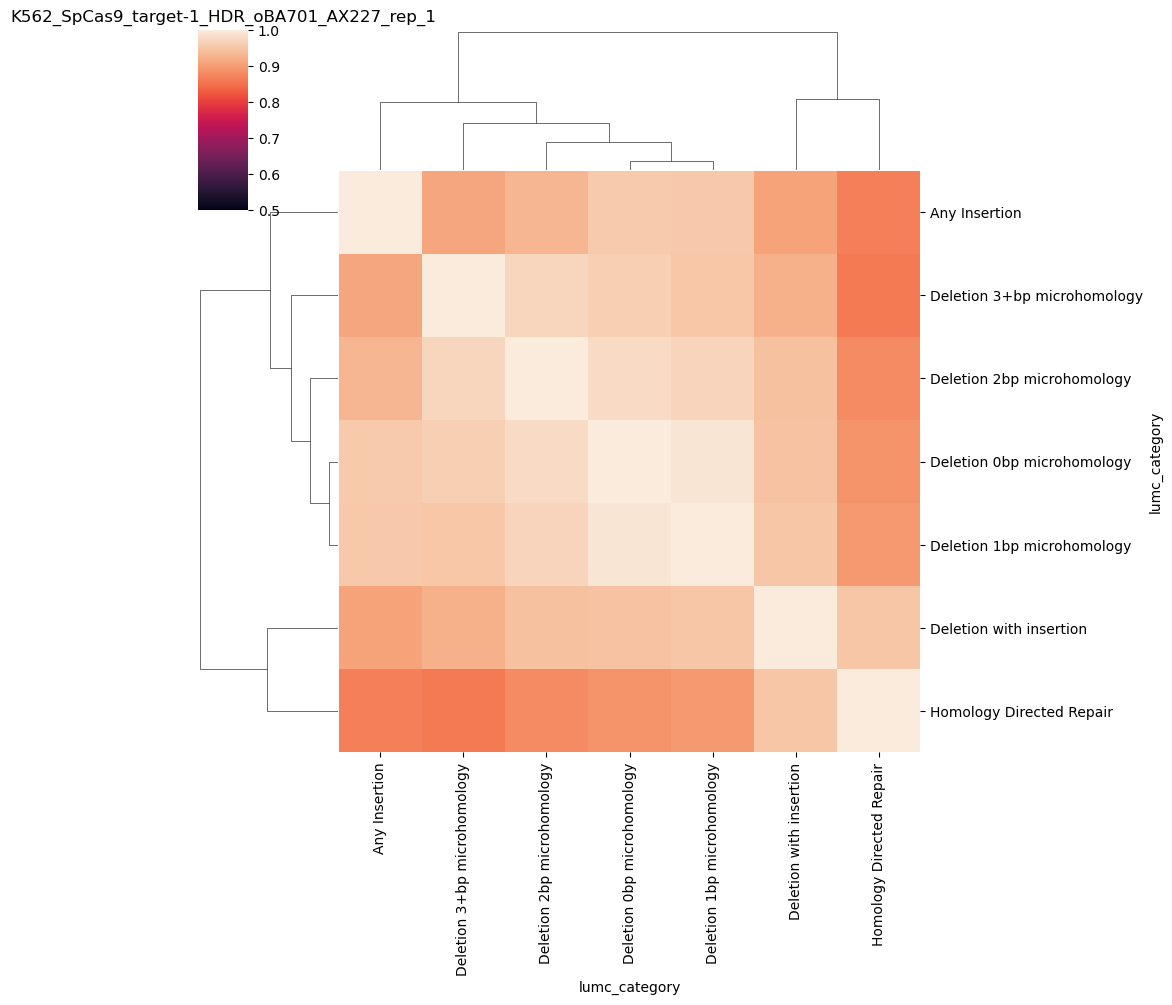

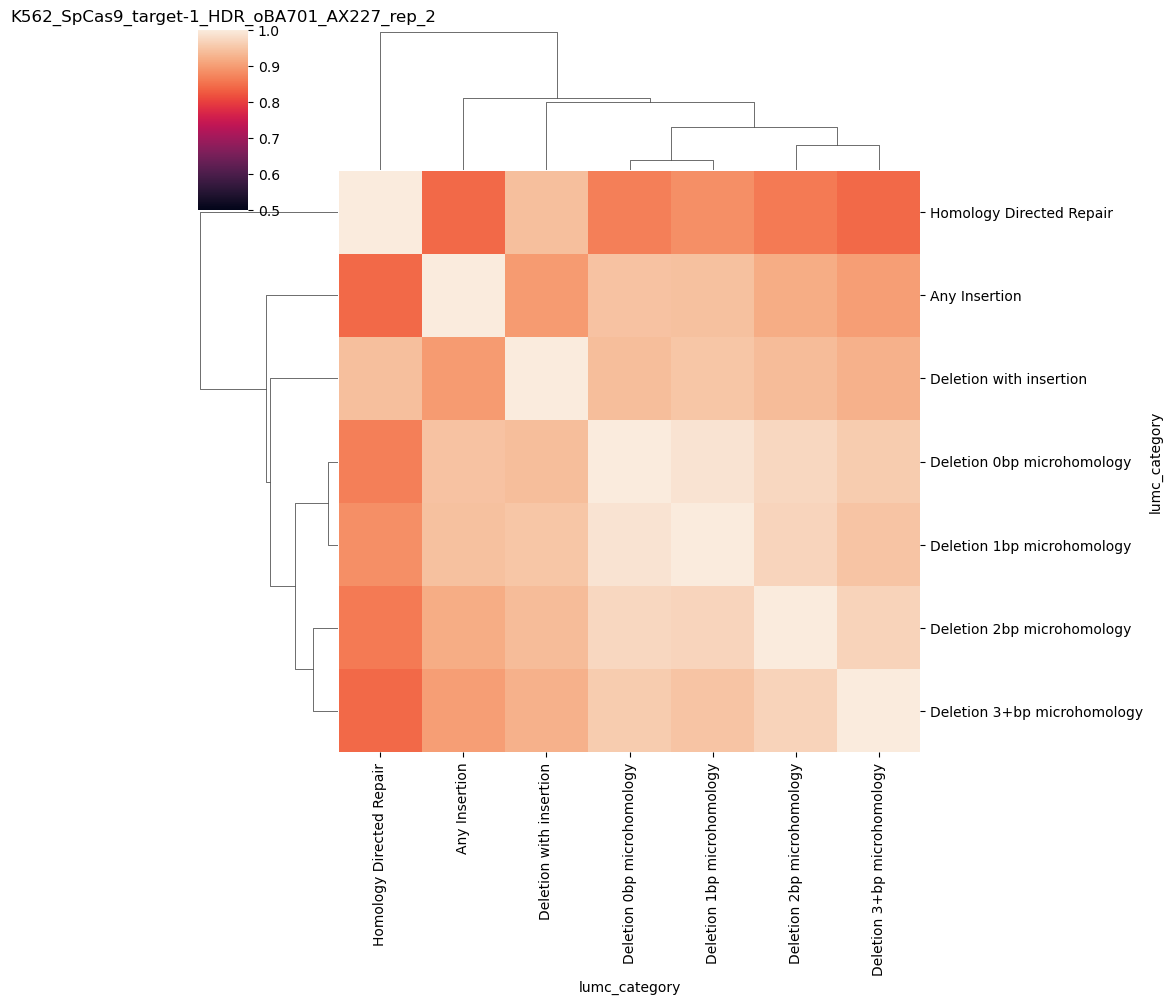

In [7]:
for alias in aliases: 
    X = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_reduced_repair_outcome_profiles.pkl".format(alias))
    X = X.loc[:, (X != 0).any(axis=0)]
    sns.clustermap(data=X.corr(), method="ward", vmin=0.5, vmax=1.0)
    plt.title(alias)

In [8]:
X = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_reduced_repair_outcome_profiles.pkl".format(aliases[0]))
X.head()

lumc_category                                                                                        Deletion 0bp microhomology  \
Target     Alias                                       Gene   Transcript Barcode                                                  
Adamson_T1 K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a P1P2       ACTL6A_-_179280860.23-P1P2                     11418.0   
                                                                         ACTL6A___179280744.23-P1P2                     85330.0   
                                                                         ACTL6A___179280849.23-P1P2                     70678.0   
                                                       Actr5  P1P2       ACTR5_-_37377127.23-P1P2                      109688.0   
                                                                         ACTR5___37377138.23-P1P2                      144612.0   

lumc_category                                                                                        Deletion 1bp microhomology  \
Target     Alias                                       Gene   Transcript Barcode                                                  
Adamson_T1 K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a P1P2       ACTL6A_-_179280860.23-P1P2                     27780.0   
                                                                         ACTL6A___179280744.23-P1P2                    157204.0   
                                                                         ACTL6A___179280849.23-P1P2                    136274.0   
                                                       Actr5  P1P2       ACTR5_-_37377127.23-P1P2                      218972.0   
                                                                         ACTR5___37377138.23-P1P2                      271906.0   

lumc_category                                                                                        Deletion 2bp microhomology  \
Target     Alias                                       Gene   Transcript Barcode                                                  
Adamson_T1 K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a P1P2       ACTL6A_-_179280860.23-P1P2                      4488.0   
                                                                         ACTL6A___179280744.23-P1P2                     19486.0   
                                                                         ACTL6A___179280849.23-P1P2                     17404.0   
                                                       Actr5  P1P2       ACTR5_-_37377127.23-P1P2                       24964.0   
                                                                         ACTR5___37377138.23-P1P2                       34268.0   

lumc_category                                                                                        Deletion with insertion  \
Target     Alias                                       Gene   Transcript Barcode                                               
Adamson_T1 K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a P1P2       ACTL6A_-_179280860.23-P1P2                  15030.0   
                                                                         ACTL6A___179280744.23-P1P2                  69890.0   
                                                                         ACTL6A___179280849.23-P1P2                  57284.0   
                                                       Actr5  P1P2       ACTR5_-_37377127.23-P1P2                    98768.0   
                                                                         ACTR5___37377138.23-P1P2                   127530.0   

lumc_category                                                                                        Homology Directed Repair  \
Target     Alias                                       Gene   Transcript Barcode                                                
Adamson_T1 K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a P1P2       ACTL6A_-_179280860

In [9]:
X.index.get_level_values("Gene").str.contains("Non").sum()

60

In [10]:
X_orig = {}
X_imputed = {}
counts = {}

for alias in aliases:
    X = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_reduced_repair_outcome_profiles.pkl".format(alias))

    idx = X.index.to_frame().reset_index(drop=True)
    idx.loc[idx["Gene"] == "Non", "Gene"] = idx.loc[idx["Gene"] == "Non", "Barcode"].str.slice(stop=-2)

    X.index = pd.MultiIndex.from_frame(idx)

    # adamson dataset has multiple "transcripts" for some genes. Remove the duplicates, as I am not sure what impact these "transcripts" have or if its a good idea to aggregate them together
    transcripts = {}
    for i, r in X.reset_index()[["Gene", "Transcript"]].iterrows():
        if r["Gene"] not in transcripts:
            transcripts[r["Gene"]] = r["Transcript"]

    X = X.loc[X.reset_index().apply(lambda x: x["Transcript"] == transcripts[x["Gene"]], axis=1).to_list(), :].droplevel(3)

    X = X.loc[:, (X != 0).any(axis=0)]
    print((X>0).sum().sum() / (X.shape[0] * X.shape[1]))

    counts[alias] = X.sum(axis=1)

    X_orig[alias] = X

    X = impute_zero_values(X, 1)
    columns = X.columns
    # X = X.div(X.sum(axis=1), axis=0)
    print(X.index.get_level_values("Gene").str.contains("non").sum(), "non-targeting controls")
    # X = X.groupby(["Gene"]).apply(stats.gmean)

    Xt = X.loc[~X.index.get_level_values("Gene").str.contains("non-"),:]
    Xt = Xt.groupby(["Gene"]).apply(stats.gmean)

    Xnt = X.loc[X.index.get_level_values("Gene").str.contains("non-"),:]
    Xnt = Xnt.groupby(["Barcode"]).apply(stats.gmean)
    Xnt.index.set_names("Gene", inplace=True)

    X = pd.concat([Xt, Xnt], axis=0)

    print(X.index.get_level_values("Gene").str.contains("non").sum(), "non-targeting controls")
    X = pd.DataFrame(X.values.tolist(), index=X.index, columns=columns)
    X = X.div(X.sum(axis=1), axis=0)
    X.columns = columns

    X_imputed[alias] = X

print("Data Ready.")

0.9993145990404386
0.00 of our data is zero
60 non-targeting controls
60 non-targeting controls
0.9993145990404386
0.00 of our data is zero
60 non-targeting controls
60 non-targeting controls
Data Ready.


In [11]:
def calculate_differential_profile(alias1, alias2, X_imputed):
    print("There are {} genes in {}".format(X_imputed[alias1].shape[0], alias1))
    print("There are {} genes in {}".format(X_imputed[alias1].shape[0], alias2))
    a = X_imputed[alias1]
    b = X_imputed[alias2]
    
    X = pd.concat([a, b], axis=0)
    columns = X.columns
    X = X.groupby(["Gene"]).apply(stats.gmean)
    X = pd.DataFrame(X.values.tolist(), index=X.index, columns=columns)
    X = X.div(X.sum(axis=1), axis=0)

    Z_case = X
    print("There are {} cases".format(Z_case.shape[0]))

    return Z_case

if PROFILE_TYPE == PAIRED_SAMPLES:
    Z = {}
    Z["Adamson_T1"] = calculate_differential_profile("K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1", "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2", X_imputed)
    print(Z["Adamson_T1"].shape[0])

if PROFILE_TYPE == SAMPLE:
    Z = X_imputed

There are 527 genes in K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1
There are 527 genes in K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2
There are 527 cases
527


In [12]:
print(X.index[X.index.to_series().str.contains("non-targ")])
print(X.index.to_series().str.contains("non-targ").sum())

Index(['non-targeting_00026', 'non-targeting_00074', 'non-targeting_00097',
       'non-targeting_00155', 'non-targeting_00240', 'non-targeting_00249',
       'non-targeting_00364', 'non-targeting_00398', 'non-targeting_00513',
       'non-targeting_00515', 'non-targeting_00566', 'non-targeting_00678',
       'non-targeting_00740', 'non-targeting_00745', 'non-targeting_00869',
       'non-targeting_00889', 'non-targeting_00948', 'non-targeting_00984',
       'non-targeting_01042', 'non-targeting_01091', 'non-targeting_01222',
       'non-targeting_01332', 'non-targeting_01358', 'non-targeting_01439',
       'non-targeting_01528', 'non-targeting_01566', 'non-targeting_01594',
       'non-targeting_01631', 'non-targeting_01959', 'non-targeting_02031',
       'non-targeting_02085', 'non-targeting_02293', 'non-targeting_02305',
       'non-targeting_02359', 'non-targeting_02607', 'non-targeting_02613',
       'non-targeting_02642', 'non-targeting_02692', 'non-targeting_02821',
       'non-

<AxesSubplot: xlabel='log10Counts', ylabel='Alias'>

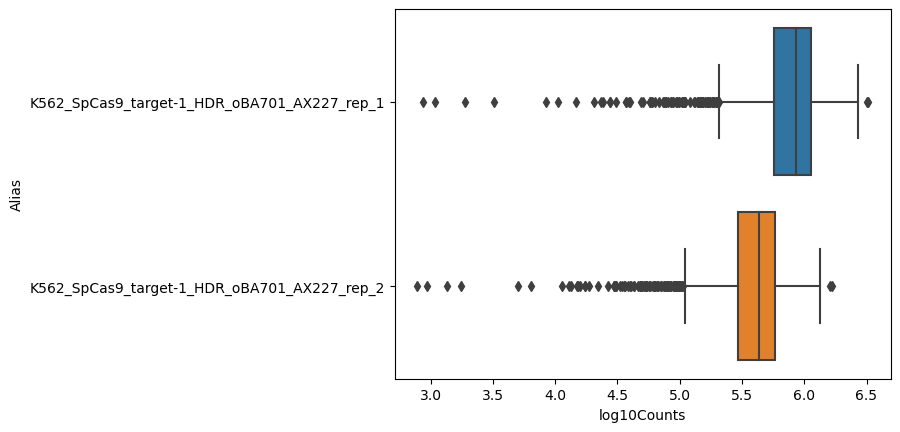

In [13]:
counts_df = pd.concat([c.reset_index().rename(columns={0: "Counts"}) for c in counts.values()])
counts_df["log10Counts"] = np.log10(counts_df["Counts"])
counts_df

sns.boxplot(data=counts_df, y="Alias", x="log10Counts")

In [14]:
df = pd.concat(X_imputed, names=["Sample"]).fillna(0)
df.head()

lumc_category                                       Deletion 0bp microhomology  \
Sample                                      Gene                                 
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a                    0.176425   
                                            Actr5                     0.181376   
                                            Actr8                     0.190534   
                                            Aicda                     0.184504   
                                            Alkbh2                    0.189304   

lumc_category                                       Deletion 1bp microhomology  \
Sample                                      Gene                                 
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a                    0.362053   
                                            Actr5                     0.369397   
                                            Actr8                     0.373348   
                                            Aicda                     0.364239   
                                            Alkbh2                    0.356852   

lumc_category                                       Deletion 2bp microhomology  \
Sample                                      Gene                                 
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a                    0.049512   
                                            Actr5                     0.039925   
                                            Actr8                     0.049253   
                                            Aicda                     0.056348   
                                            Alkbh2                    0.054539   

lumc_category                                       Deletion with insertion  \
Sample                                      Gene                              
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a                 0.168670   
                                            Actr5                  0.170009   
                                            Actr8                  0.166768   
                                            Aicda                  0.172529   
                                            Alkbh2                 0.170885   

lumc_category                                       Homology Directed Repair  \
Sample                                      Gene                               
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a                  0.036964   
                                            Actr5                   0.048849   
                                            Actr8                   0.049737   
                                            Aicda                   0.049311   
                                            Alkbh2                  0.051923   

lumc_category                                       Any Insertion  \
Sample                                      Gene                    
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a       0.179460   
                                            Actr5        0.160807   
                                            Actr8        0.144000   
                                            Aicda        0.138997   
                                            Alkbh2       0.140536   

lumc_category                                       Deletion 3+bp microhomology  
Sample                                      Gene                                 
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a                     0.026915  
                                            Actr5                      0.029638  
                                            Actr8                      0.026359  
                                            Aicda                      0.034072  
                                            Alkbh2                     0.035961

### General Profiles Per Target Site

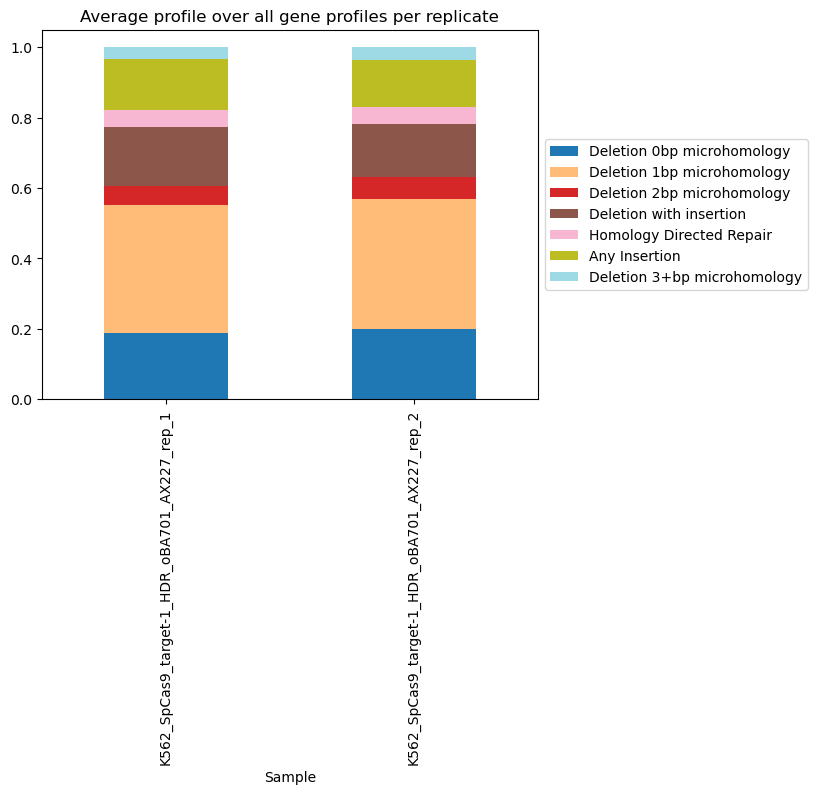

In [15]:
barplot_df = df.groupby("Sample").mean().fillna(0)
f = plt.figure()
plt.title('Average profile over all gene profiles per replicate', color='black')
barplot_df.plot(kind="bar", stacked=True, ax=f.gca(), colormap="tab20")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

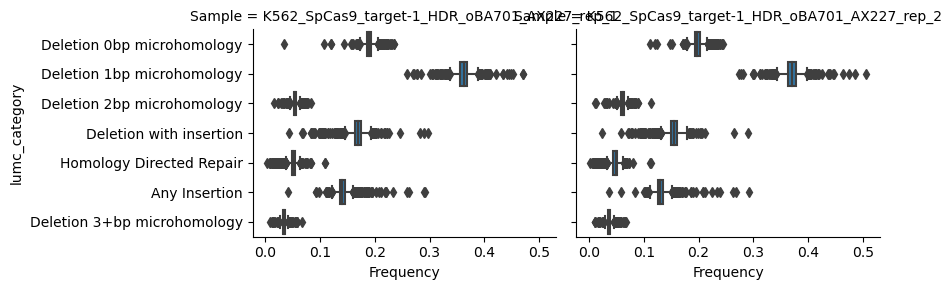

In [16]:
facetplot_df = df.stack()
facetplot_df.name = "Frequency"
facetplot_df = facetplot_df.reset_index()
# facetplot_df["Sample"] = facetplot_df["Sample"].apply(lambda x: x.split("_")[-1])
g = sns.FacetGrid(facetplot_df, col="Sample", height = 3, col_wrap=2, col_order=df.index.unique("Sample"), aspect=1.5)
g.map_dataframe(sns.boxplot, y="lumc_category", x="Frequency")


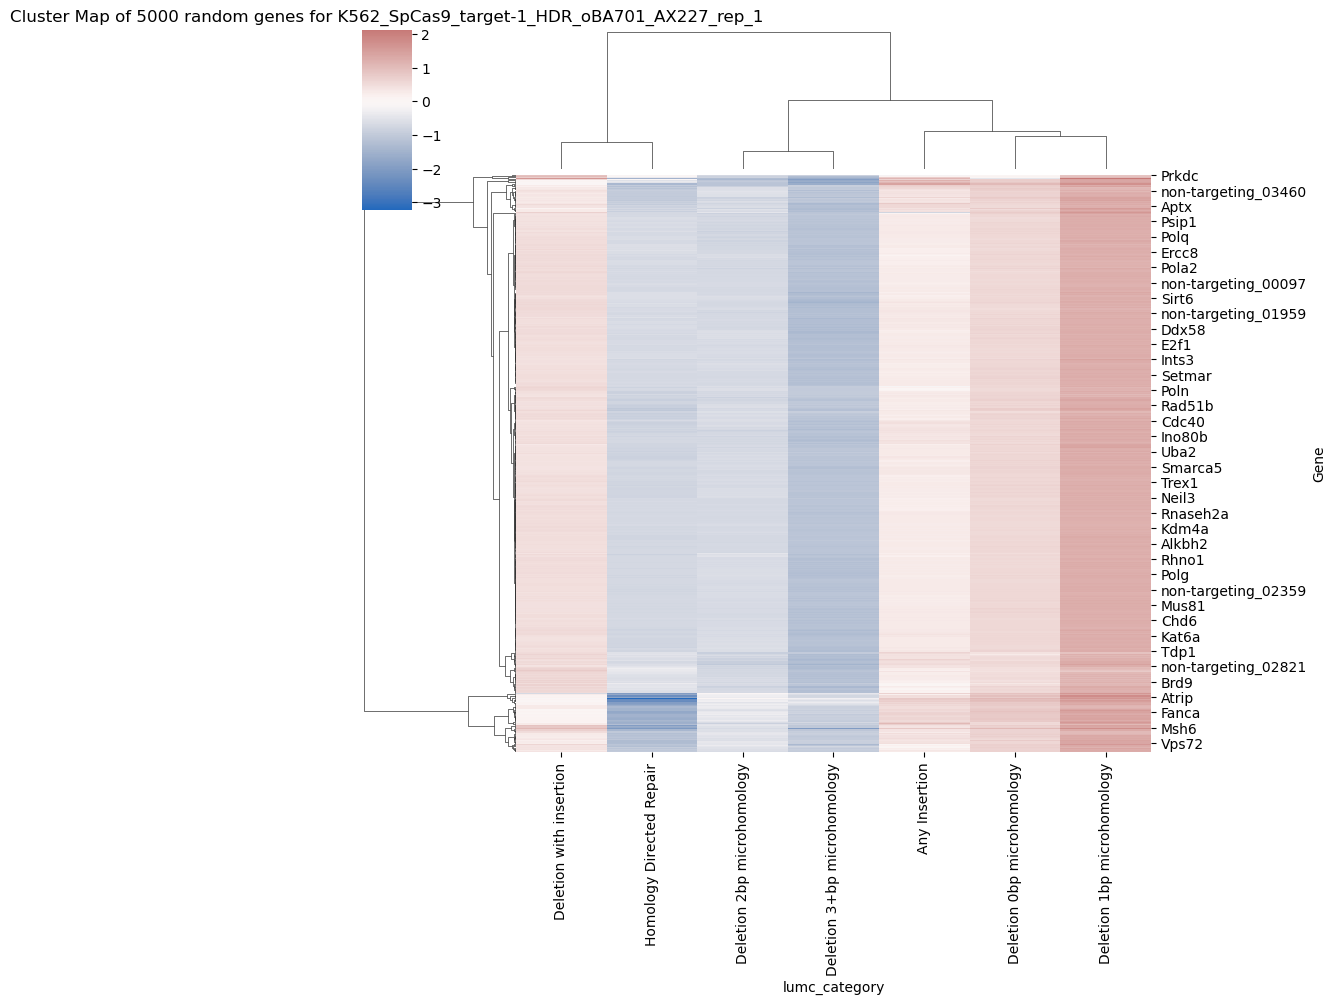

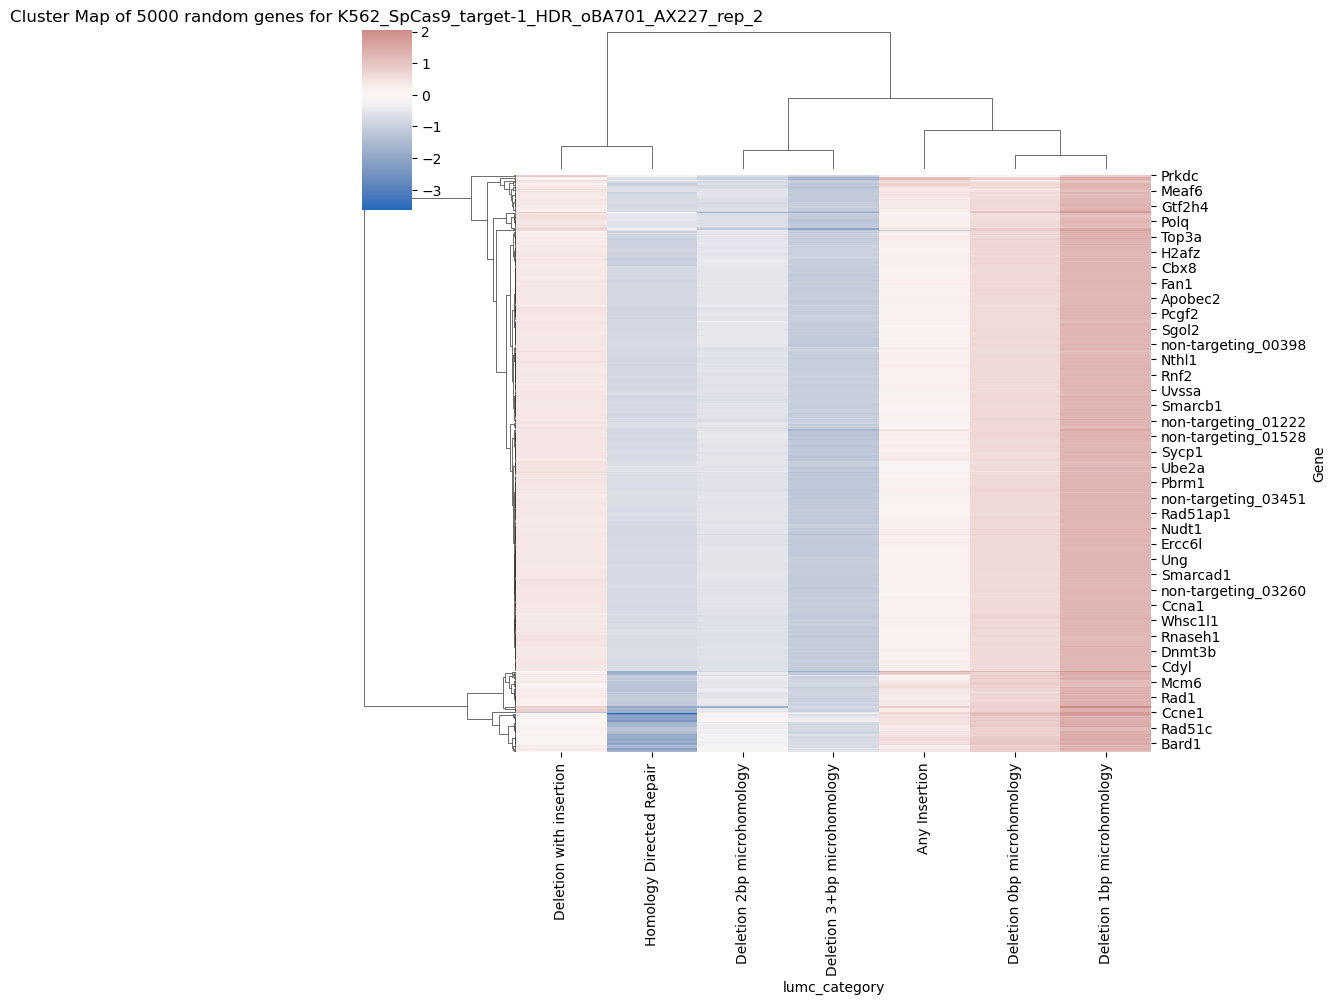

In [17]:
for alias in aliases:
    clustermap_df = df.loc[alias,:]
    clustermap_df = clustermap_df.loc[:, (clustermap_df != 0).any(axis=0)]
    clustermap_df = pd.DataFrame(clr(clustermap_df), columns=clustermap_df.columns, index=clustermap_df.index)
    sns.clustermap(clustermap_df, metric="correlation", center=0, cmap="vlag", method="ward")
    plt.title("Cluster Map of 5000 random genes for {}".format(alias))

### Question 1b:

Does our outlier detection method identify outliers better than simple standard PCA outlier detection?

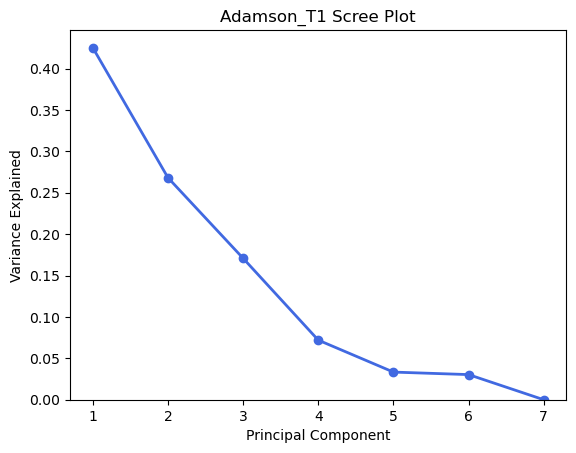

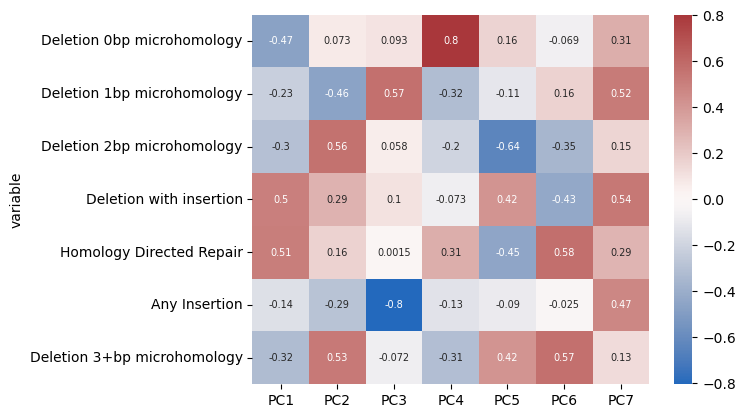

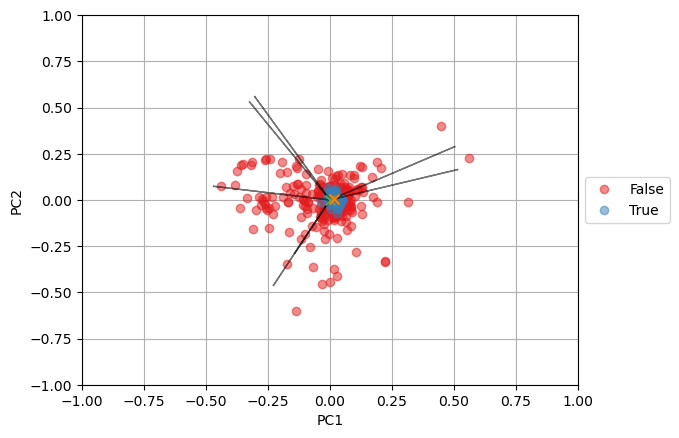

In [18]:
results = {}
for alias in Z:
    result_genes = Z[alias].index.to_list()
    Z_st = StandardScaler().fit_transform(Z[alias])

    pca_scores, loadings, explained_variance_ratio, distances, pvalues, _, _ = outlier_detection(Z_st, EmpiricalCovariance())

    fig, ax = plt.subplots()
    screeplot(explained_variance_ratio, ax, alias)
    plt.show()

    loadings_df, z = loadingsplot(loadings, Z[alias].columns.to_list())
    plt.show()

    #Call the function. Use only the 2 PCs.
    pcs_to_analyse = [0,1]
    results[alias] = pca_scores, loadings, explained_variance_ratio, distances, pvalues

    is_control = pd.Series(result_genes).str.contains("non-target")
    scalex, scaley = biplot(pca_scores[:,pcs_to_analyse], loadings_df.iloc[:,pcs_to_analyse].values, labels=None, components=loadings_df.iloc[:,pcs_to_analyse].columns, groups=is_control)

    #create grids
    estimated_x = pca_scores[is_control][:, 0].mean()
    estimated_y = pca_scores[is_control][:, 1].mean()

    plt.scatter(0, 0, color=sns.color_palette("Set1", 12)[2], s=50, zorder=100, marker='x')
    plt.scatter(estimated_x * scalex, estimated_y* scaley, color=sns.color_palette("Set1", 12)[4], s=50, zorder=100, marker='x')
    plt.show()


In [19]:
np.sum(np.abs(loadings))

15.550737145033805

In [20]:
pvalue_dfs = [pd.DataFrame({"pvalues": results[alias][-1],
"distances": results[alias][-2]}, index=result_genes) for alias in sorted(Z.keys())]
pvalue_dfs

results_df = pd.concat(pvalue_dfs, axis=1, keys=sorted(Z.keys()))
results_df = results_df.join(counts_df.loc[:,["Alias", "Gene", "Counts"]].groupby(['Gene', "Alias"]).median().reset_index().pivot(index="Gene", columns=["Alias"]).reorder_levels([1,0], axis=1)).sort_index(axis=1)
results_df.columns.names = ["Sample", "Measure"]
results_df.head()

Sample  Adamson_T1           K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1  \
Measure  distances   pvalues                                      Counts   
Actl6a    5.864065  0.438589                                    379484.0   
Actr5     6.913198  0.328949                                    592174.0   
Actr8     2.820576  0.831006                                    746934.0   
Aicda     0.733053  0.993750                                   1253086.0   
Alkbh2    0.522531  0.997553                                   1067866.0   

Sample  K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2  
Measure                                      Counts  
Actl6a                                     193906.0  
Actr5                                      302414.0  
Actr8                                      395884.0  
Aicda                                      615286.0  
Alkbh2                                     543284.0

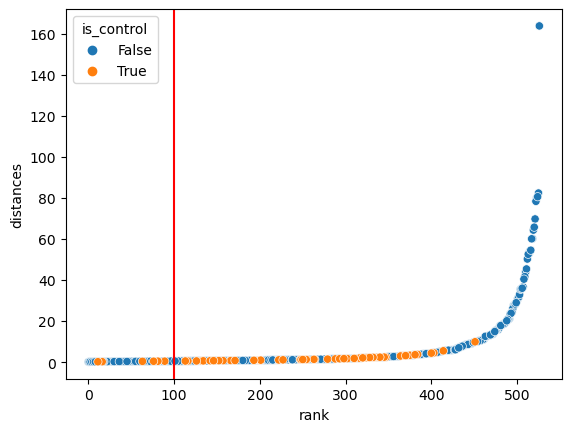

In [21]:
for alias in sorted(Z.keys()):
    r = results_df.xs(alias, level="Sample", axis=1)
    r["rank"] = r.distances.argsort().argsort()
    r["is_control"] = r.index.to_series().str.contains("non-target")
    sns.scatterplot(data=r, x="rank", y="distances", hue="is_control")
    plt.axvline(100, c='r')
    plt.show()

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-57.204390195174213 > -58.001797032520066). You may want to try with a higher value of support_fraction (current value: 0.509).
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-56.732342102379135 > -56.953060081151065). You may want to try with a higher value of support_fraction (current value: 0.509).
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust

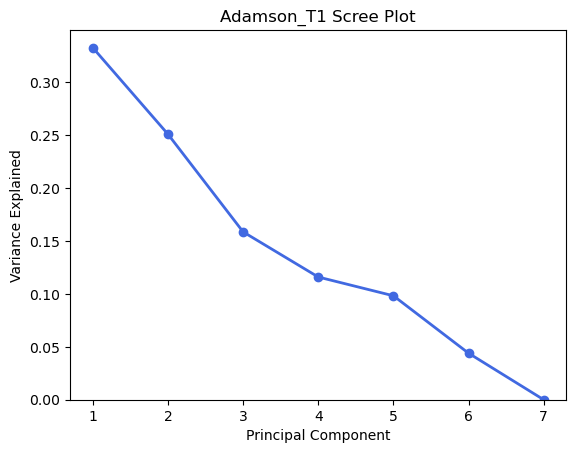

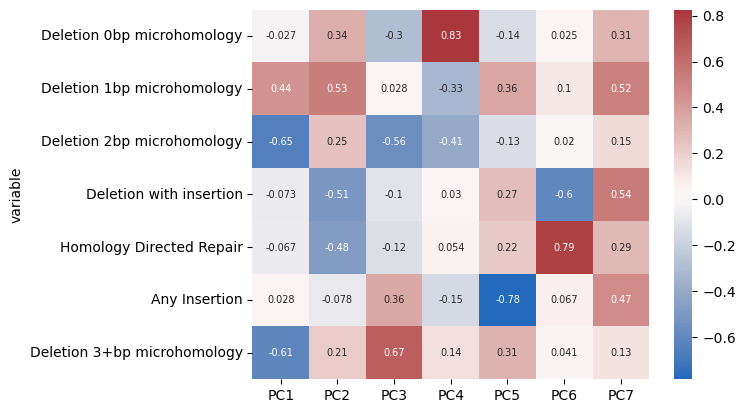

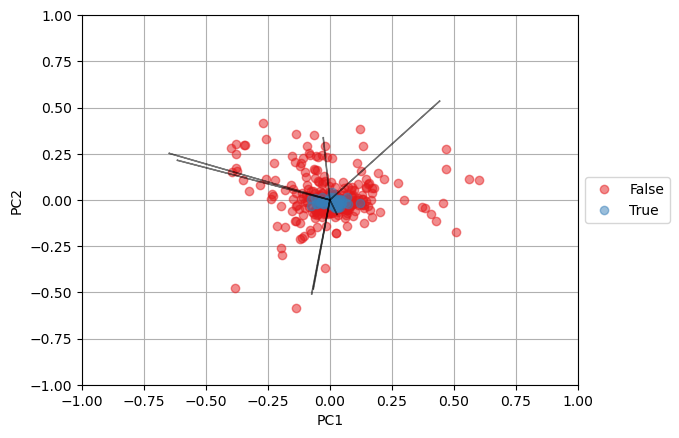

In [22]:
results = {}
for alias in Z:
    result_genes = Z[alias].index.to_list()
    Z_st = StandardScaler().fit_transform(Z[alias])

    pca_scores, loadings, explained_variance_ratio, distances, pvalues, _, _ = outlier_detection(Z_st, MinCovDet(random_state=1))

    fig, ax = plt.subplots()
    screeplot(explained_variance_ratio, ax, alias)
    plt.show()

    loadings_df, z = loadingsplot(loadings, Z[alias].columns.to_list())
    plt.show()

    #Call the function. Use only the 2 PCs.
    pcs_to_analyse = [0,1]
    results[alias] = pca_scores, loadings, explained_variance_ratio, distances, pvalues

    is_control = pd.Series(result_genes).str.contains("non-target")
    biplot(pca_scores[:,pcs_to_analyse], loadings_df.iloc[:,pcs_to_analyse].values, labels=None, components=loadings_df.iloc[:,pcs_to_analyse].columns, groups=is_control)
    plt.show()


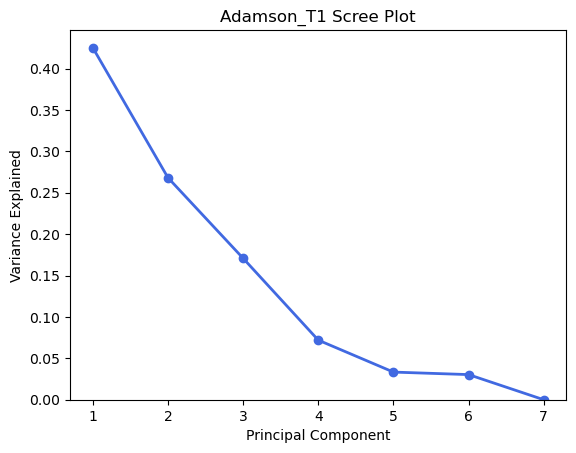

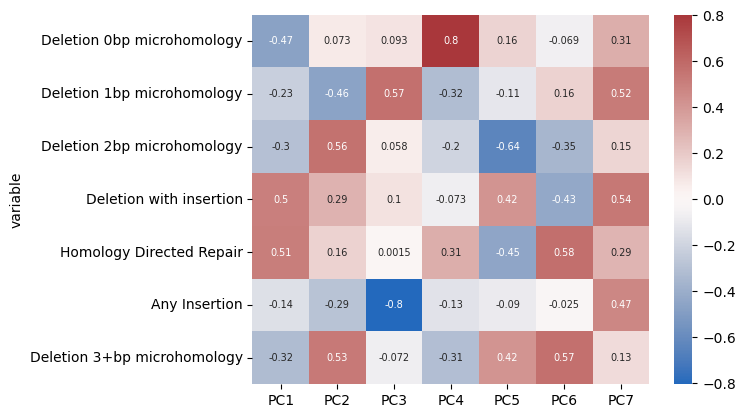

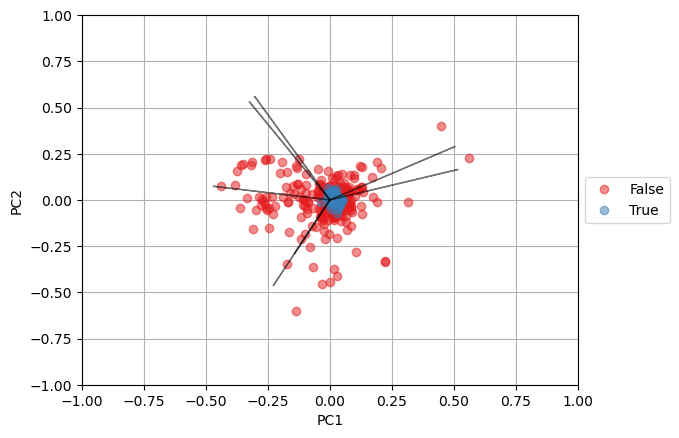

In [23]:
results = {}
for alias in Z:
    pca_scores, loadings, explained_variance_ratio, distances, pvalues, _, _ = outlier_detection(Z[alias] , EmpiricalCovariance())
    result_genes = Z[alias].index.to_list()

    fig, ax = plt.subplots()
    screeplot(explained_variance_ratio, ax, alias)
    plt.show()

    loadings_df, z = loadingsplot(loadings, Z[alias].columns.to_list())
    plt.show()

    #Call the function. Use only the 2 PCs.
    pcs_to_analyse = [0,1]
    results[alias] = pca_scores, loadings, explained_variance_ratio, distances, pvalues

    is_control = Z[alias].index.to_series().str.contains("non-target")
    biplot(pca_scores[:,pcs_to_analyse], loadings_df.iloc[:,pcs_to_analyse].values, labels=None, components=loadings_df.iloc[:,pcs_to_analyse].columns, groups=pd.Series(is_control))
    plt.show()

### Question 1a:

Does our outlier detection technique identify the controls?

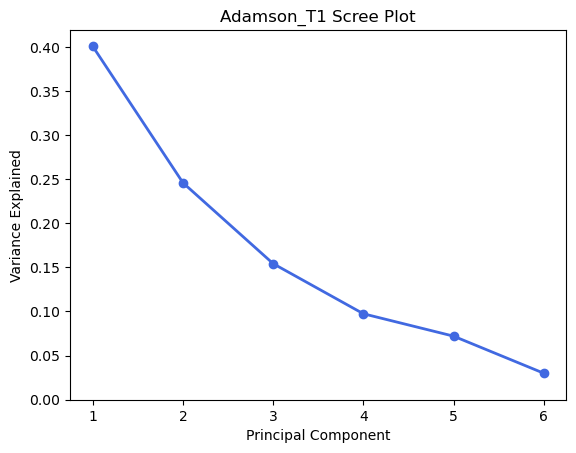

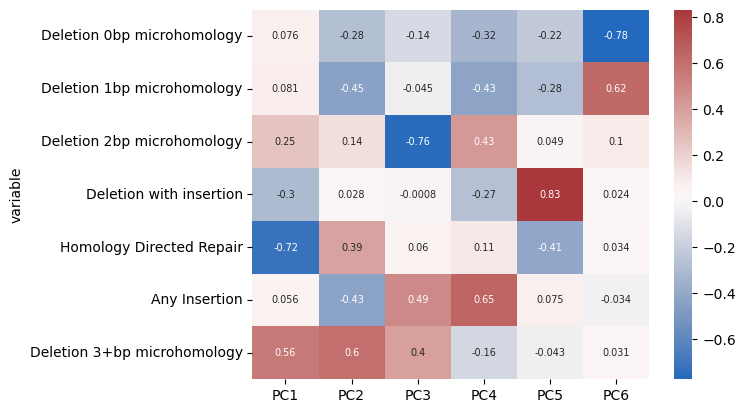

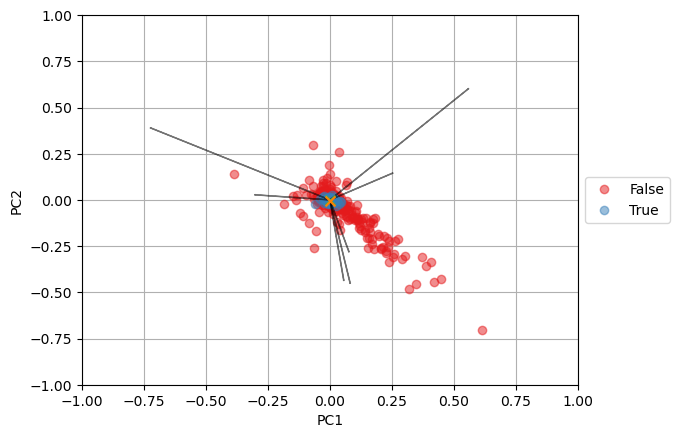

In [24]:
results = {}
for alias in Z:
    pca_scores, loadings, explained_variance_ratio, distances, pvalues, _ = logratio_outlier_detection(Z[alias], MinCovDet(random_state=0))
    result_genes = Z[alias].index.to_list()

    fig, ax = plt.subplots()
    screeplot(explained_variance_ratio, ax, alias)
    plt.show()

    loadings_df, z = loadingsplot(loadings, Z[alias].columns.to_list())
    plt.show()

    #Call the function. Use only the 2 PCs.
    pcs_to_analyse = [0,1]
    results[alias] = pca_scores, loadings, explained_variance_ratio, distances, pvalues

    is_control = pd.Series(result_genes).str.contains("non-target")
    scalex, scaley = biplot(pca_scores[:,pcs_to_analyse], loadings_df.iloc[:,pcs_to_analyse].values, labels=None, components=loadings_df.iloc[:,pcs_to_analyse].columns, groups=is_control)

    estimated_x = pca_scores[is_control][:, 0].mean()
    estimated_y = pca_scores[is_control][:, 1].mean()

    plt.scatter(0, 0, color=sns.color_palette("Set1", 12)[2], s=50, zorder=100, marker='x')
    plt.scatter(estimated_x * scalex, estimated_y* scaley, color=sns.color_palette("Set1", 12)[4], s=50, zorder=100, marker='x')

    # plt.contour(xedges, yedges, G, cmap = "jet")
    plt.show()


In [25]:
np.sum(np.abs(loadings))

12.150470307941127

In [26]:
pvalue_dfs = [pd.DataFrame({"pvalues": results[alias][-1],
"distances": results[alias][-2]}, index=result_genes) for alias in sorted(Z.keys())]
pvalue_dfs

results_df = pd.concat(pvalue_dfs, axis=1, keys=sorted(Z.keys()))
results_df = results_df.join(counts_df.loc[:,["Alias", "Gene", "Counts"]].groupby(['Gene', "Alias"]).median().reset_index().pivot(index="Gene", columns=["Alias"]).reorder_levels([1,0], axis=1)).sort_index(axis=1)
results_df.columns.names = ["Sample", "Measure"]
results_df.head()

Sample  Adamson_T1               K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1  \
Measure  distances       pvalues                                      Counts   
Actl6a   80.174457  7.771561e-16                                    379484.0   
Actr5    48.234446  3.181261e-09                                    592174.0   
Actr8    17.518850  3.613989e-03                                    746934.0   
Aicda     2.503261  7.760039e-01                                   1253086.0   
Alkbh2    2.084439  8.373423e-01                                   1067866.0   

Sample  K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2  
Measure                                      Counts  
Actl6a                                     193906.0  
Actr5                                      302414.0  
Actr8                                      395884.0  
Aicda                                      615286.0  
Alkbh2                                     543284.0

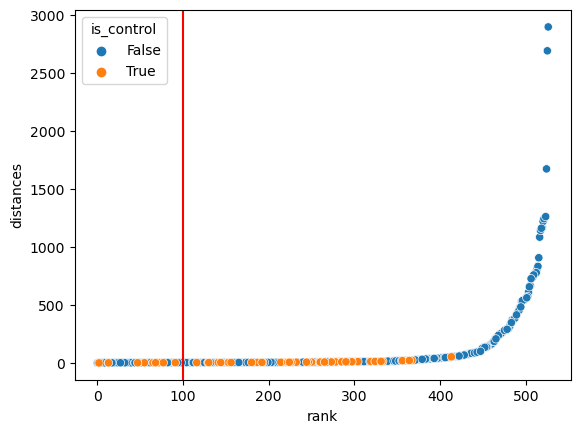

In [27]:
for alias in sorted(Z.keys()):
    r = results_df.xs(alias, level="Sample", axis=1)
    r["rank"] = r.distances.argsort().argsort()
    r["is_control"] = r.index.to_series().str.contains("non-target")
    sns.scatterplot(data=r, x="rank", y="distances", hue="is_control")
    plt.axvline(100, c='r')
    plt.show()

In [28]:
PROFILE_TYPE

'paired-replicates'

In [29]:
results_df.to_pickle(get_experiment_artifacts(profile_type=PROFILE_TYPE) + "adamson_outlier_results.pkl")
pkl.dump(Z, open("{}/imputed_adamson_sample_data.pkl".format(get_experiment_artifacts(profile_type=PROFILE_TYPE)), "wb"))

In [30]:
outliers = results_df.dropna()
outliers = outliers.xs("distances", level=1, axis=1).min(axis=1).sort_values().head(100)
outliers.head()

Cetn2       0.337001
Rhno1       0.427338
Apobec3g    0.568571
Smug1       0.587559
Hus1b       0.826040
dtype: float64

In [31]:
controls = X.loc[X.index.to_series().str.contains("non-target"), :]
print(controls.shape)
controls.head()

(60, 7)


lumc_category,Deletion 0bp microhomology,Deletion 1bp microhomology,Deletion 2bp microhomology,Deletion with insertion,Homology Directed Repair,Any Insertion,Deletion 3+bp microhomology
Gene,,,,,,,
non-targeting_00026,0.193544,0.368427,0.063319,0.154538,0.055027,0.128470,0.036677
non-targeting_00074,0.202675,0.362595,0.061772,0.170018,0.043944,0.123524,0.035471
non-targeting_00097,0.193096,0.376468,0.062917,0.158796,0.048215,0.126090,0.034418
non-targeting_00155,0.202353,0.375436,0.053857,0.152220,0.052177,0.126381,0.037576
non-targeting_00240,0.192113,0.363633,0.062548,0.167752,0.049871,0.129640,0.034443


### Combined analysis

- Do the samples from LUMC and Adamson report the same outliers?
- Do they agree among themselves?
- Do their rankings agree?

In [32]:
lumc_results_df = pd.read_pickle(get_interim_dir() + "samplewise_outlier_results.pkl")
print(lumc_results_df.shape)

lumc_psuedo_controls = lumc_results_df.dropna()
lumc_psuedo_controls = lumc_psuedo_controls[~lumc_psuedo_controls.xs("reject", level=1, axis=1).all(axis=1)].xs("pvalues", level=1, axis=1).min(axis=1).sort_values().tail(100)
lumc_psuedo_controls = lumc_psuedo_controls.index.to_list()
print(lumc_psuedo_controls[:5])

(18213, 30)
['Bag3', '4930404N11Rik', 'Npr1', 'Fam43a', 'Slc17a3']


In [33]:
X_imputed = pkl.load(open("{}/imputed_adamson_sample_data.pkl".format(get_experiment_artifacts(profile_type=PROFILE_TYPE)), "rb"))

print("Data Ready.")

Data Ready.


In [51]:
X_imputed["Adamson_T1"]

lumc_category,Deletion 0bp microhomology,Deletion 1bp microhomology,Deletion 2bp microhomology,Deletion with insertion,Homology Directed Repair,Any Insertion,Deletion 3+bp microhomology
Gene,,,,,,,
Actl6a,0.182632,0.367412,0.053167,0.157311,0.038832,0.169872,0.030775
Actr5,0.188649,0.370201,0.043995,0.165087,0.048275,0.152818,0.030975
Actr8,0.197087,0.374039,0.052188,0.159505,0.051384,0.137595,0.028203
Aicda,0.189794,0.366840,0.059621,0.165860,0.050356,0.132990,0.034540
Alkbh2,0.191525,0.363685,0.058760,0.163226,0.053326,0.133315,0.036163
...,...,...,...,...,...,...,...
non-targeting_03451,0.194141,0.381695,0.057819,0.154147,0.047833,0.133632,0.030733
non-targeting_03460,0.199941,0.370172,0.053999,0.170872,0.042647,0.135941,0.026429
non-targeting_03512,0.191639,0.377796,0.053770,0.154426,0.050546,0.135542,0.036281


<AxesSubplot: xlabel='log10Counts', ylabel='Alias'>

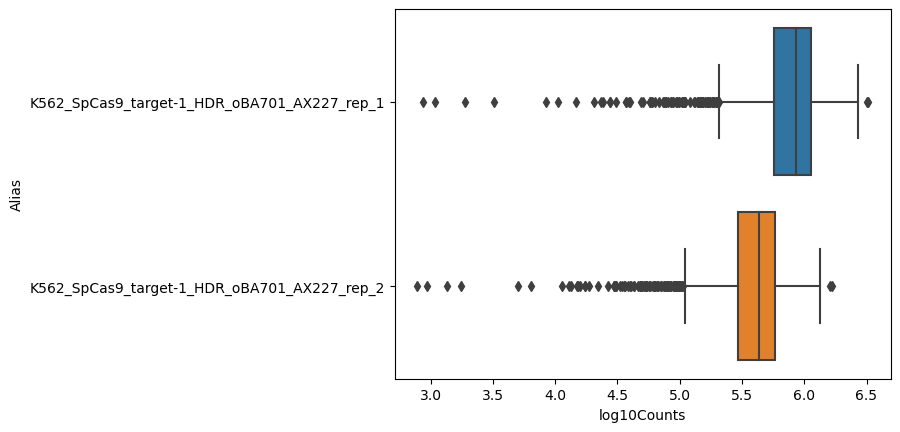

In [34]:
counts_df = pd.concat([c.reset_index().rename(columns={0: "Counts"}) for c in counts.values()])
counts_df["log10Counts"] = np.log10(counts_df["Counts"])
counts_df

sns.boxplot(data=counts_df, y="Alias", x="log10Counts")

In [35]:
df = pd.concat(X_imputed, names=["Sample"]).fillna(0)
df

lumc_category                   Deletion 0bp microhomology  \
Sample     Gene                                              
Adamson_T1 Actl6a                                 0.182632   
           Actr5                                  0.188649   
           Actr8                                  0.197087   
           Aicda                                  0.189794   
           Alkbh2                                 0.191525   
...                                                    ...   
           non-targeting_03451                    0.194141   
           non-targeting_03460                    0.199941   
           non-targeting_03512                    0.191639   
           non-targeting_03589                    0.183587   
           non-targeting_03612                    0.198831   

lumc_category                   Deletion 1bp microhomology  \
Sample     Gene                                              
Adamson_T1 Actl6a                                 0.367412   
           Actr5                                  0.370201   
           Actr8                                  0.374039   
           Aicda                                  0.366840   
           Alkbh2                                 0.363685   
...                                                    ...   
           non-targeting_03451                    0.381695   
           non-targeting_03460                    0.370172   
           non-targeting_03512                    0.377796   
           non-targeting_03589                    0.375483   
           non-targeting_03612                    0.364955   

lumc_category                   Deletion 2bp microhomology  \
Sample     Gene                                              
Adamson_T1 Actl6a                                 0.053167   
           Actr5                                  0.043995   
           Actr8                                  0.052188   
           Aicda                                  0.059621   
           Alkbh2                                 0.058760   
...                                                    ...   
           non-targeting_03451                    0.057819   
           non-targeting_03460                    0.053999   
           non-targeting_03512                    0.053770   
           non-targeting_03589                    0.055001   
           non-targeting_03612                    0.057240   

lumc_category                   Deletion with insertion  \
Sample     Gene                                           
Adamson_T1 Actl6a                              0.157311   
           Actr5                               0.165087   
           Actr8                               0.159505   
           Aicda                               0.165860   
           Alkbh2                              0.163226   
...                                                 ...   
           non-targeting_03451                 0.154147   
           non-targeting_03460                 0.170872   
           non-targeting_03512                 0.154426   
           non-targeting_03589                 0.174768   
           non-targeting_03612                 0.160109   

lumc_category                   Homology Directed Repair  Any Insertion  \
Sample     Gene                                                           
Adamson_T1 Actl6a                               0.038832       0.169872   
           Actr5                                0.048275       0.152818   
           Actr8                                0.051384       0.137595   
           Aicda                                0.050356       0.132990   
           Alkbh2                               0.053326       0.133315   
...                                                  ...            ...   
           non-targeting_03451                  0.047833       0.133632   
           non-targeting_03460                  0.042647       0.135941   
           non-targeting_03512                  0.050546     

In [36]:
all_genes = df.index.get_level_values("Gene").value_counts()
all_genes = all_genes[all_genes == df.index.get_level_values("Sample").nunique()].index

In [37]:
df.index.unique("Sample")

Index(['Adamson_T1'], dtype='object', name='Sample')

(2948, 7)


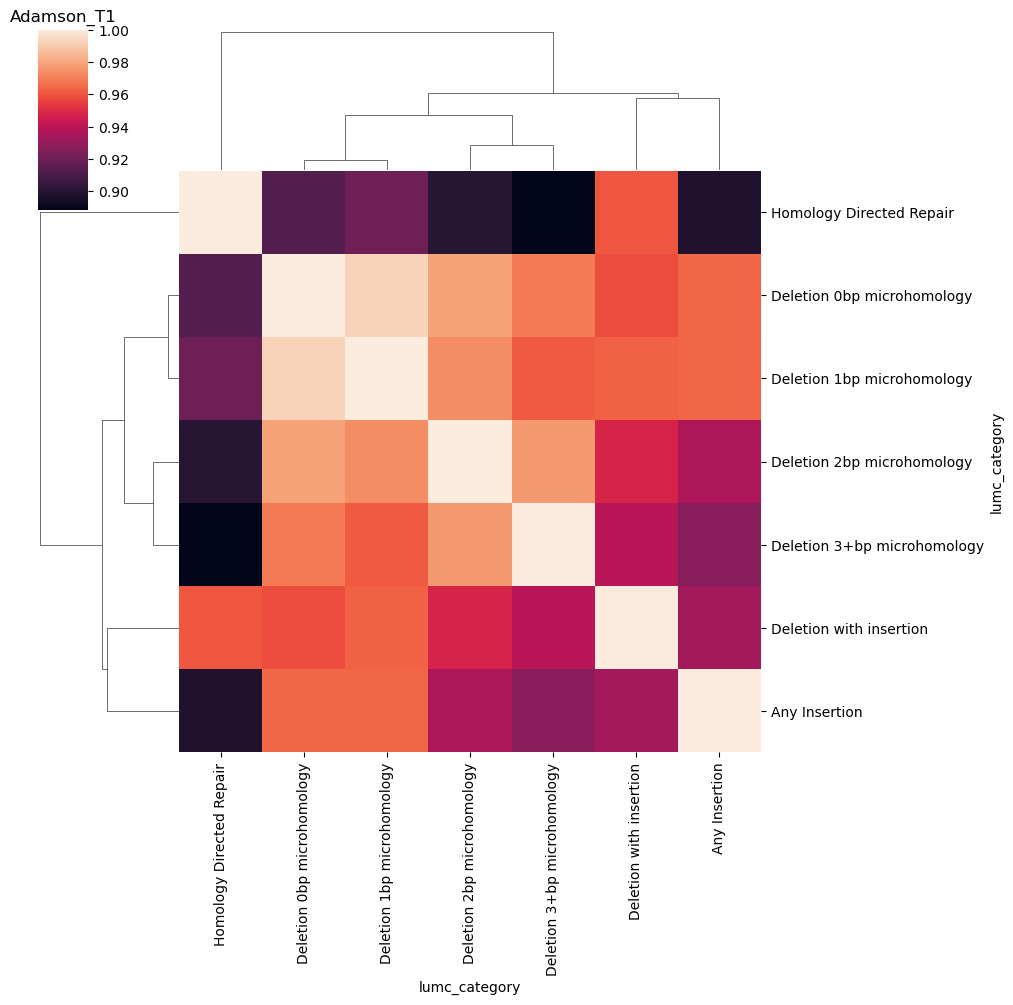

In [38]:
for alias in df.index.unique("Sample"): 
    X = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_reduced_repair_outcome_profiles.pkl".format(alias))
    X = X.loc[:, (X != 0).any(axis=0)]
    X = X.loc[X.index.get_level_values("Gene").isin(all_genes), :]
    print(X.shape)
    sns.clustermap(data=X.corr(), method="ward")
    plt.title(alias)

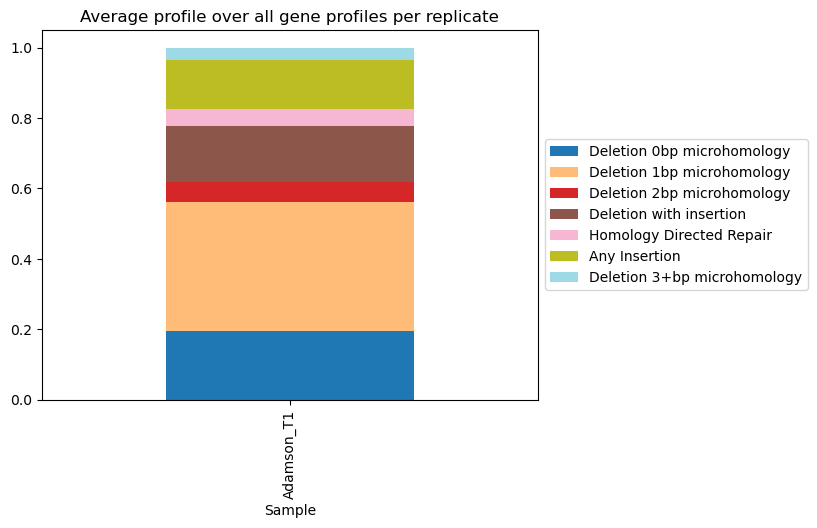

In [39]:
barplot_df = df.loc[df.index.get_level_values("Gene").isin(all_genes), :].groupby("Sample").mean().fillna(0)
f = plt.figure()
plt.title('Average profile over all gene profiles per replicate', color='black')
barplot_df.plot(kind="bar", stacked=True, ax=f.gca(), colormap="tab20")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

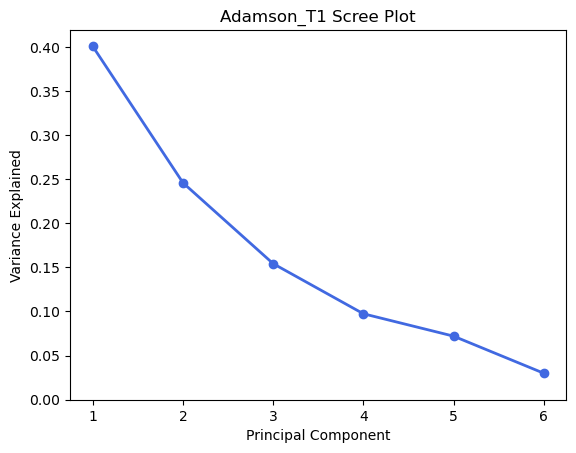

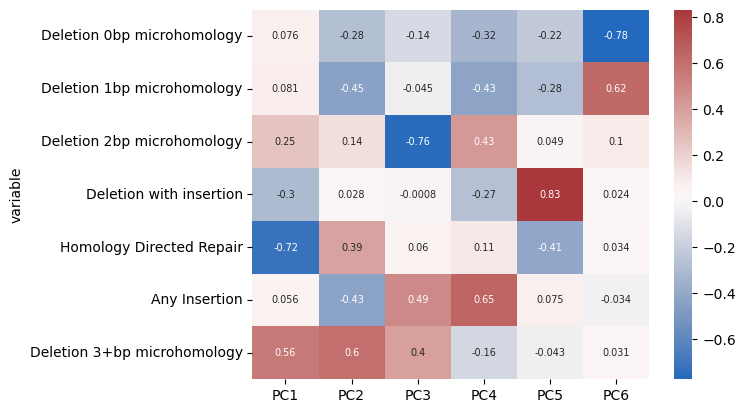

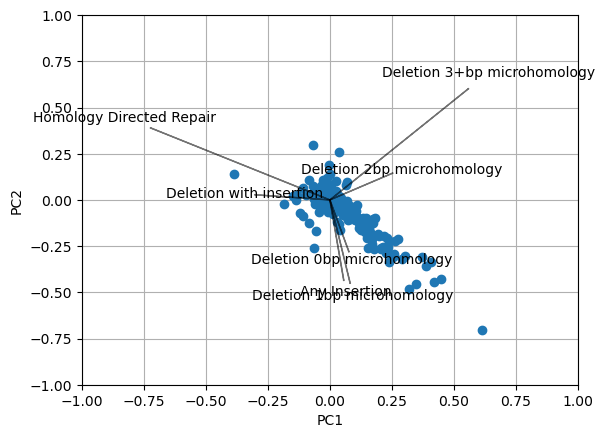

In [40]:
results = {}
Z = {}
for alias in df.index.unique("Sample"):
    Z[alias] = X_imputed[alias].loc[all_genes,:]
    pca_scores, loadings, explained_variance_ratio, distances, pvalues, _ = logratio_outlier_detection(Z[alias], MinCovDet(random_state=0))
    results[alias] = pca_scores, loadings, explained_variance_ratio, distances, pvalues

    fig, ax = plt.subplots()
    screeplot(explained_variance_ratio, ax, alias)
    plt.show()

    loadings_df, z = loadingsplot(loadings, Z[alias].columns.to_list())
    plt.show()

    #Call the function. Use only the 2 PCs.
    pcs_to_analyse = [0,1]
    biplot(pca_scores[:,pcs_to_analyse], loadings_df.iloc[:,pcs_to_analyse].values, labels=loadings_df.index, components=loadings_df.iloc[:,pcs_to_analyse].columns)
    plt.show()

In [41]:
pvalue_dfs = [pd.DataFrame({"pvalues": results[alias][-1],
"distances": results[alias][-2]}, index=all_genes) for alias in list(results.keys())]
len(pvalue_dfs)
for pvalue_df in pvalue_dfs:
    corrected = multipletests(pvalue_df["pvalues"])
    pvalue_df["reject"] = corrected[0]
    pvalue_df["pvals_corrected"] = corrected[1]

results_df = pd.concat(pvalue_dfs, axis=1, keys=list(results.keys()))
results_df = results_df.join(counts_df.loc[:,["Alias", "Gene", "Counts"]].groupby(['Gene', "Alias"]).median().reset_index().pivot(index="Gene", columns=["Alias"]).reorder_levels([1,0], axis=1)).sort_index(axis=1)
results_df.columns.names = ["Sample", "Measure"]
results_df.head()

Sample  Adamson_T1                                       \
Measure  distances pvals_corrected       pvalues reject   
Actl6a   80.174457    3.372858e-13  7.771561e-16   True   
Smarca5  23.029502    1.157143e-01  3.332104e-04  False   
Smarca2   1.372716    1.000000e+00  9.272745e-01  False   
Slx4     20.258673    3.321075e-01  1.117458e-03  False   
Skiv2l   12.016340    9.999846e-01  3.456457e-02  False   

Sample  K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1  \
Measure                                      Counts   
Actl6a                                     379484.0   
Smarca5                                    956366.0   
Smarca2                                   1158866.0   
Slx4                                       714044.0   
Skiv2l                                     750524.0   

Sample  K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2  
Measure                                      Counts  
Actl6a                                     193906.0  
Smarca5                                    405696.0  
Smarca2                                    569846.0  
Slx4                                       422684.0  
Skiv2l                                     373986.0

In [42]:
results_df.xs("distances", level="Measure", axis=1)

Sample,Adamson_T1
Actl6a,80.174457
Smarca5,23.029502
Smarca2,1.372716
Slx4,20.258673
Skiv2l,12.016340
...,...
Hp1bp3,2.776318
Hnrnpul2,13.447787
Hnrnpul1,3.361930
Hnrnpa1,98.189857


In [43]:
outliers = results_df.dropna()
outliers = outliers[outliers.xs("reject", level=1, axis=1).all(axis=1)].xs("pvalues", level=1, axis=1).min(axis=1).sort_values()
outliers

Dclre1c    0.000000
Mutyh      0.000000
Baz1b      0.000000
Brca1      0.000000
Brca2      0.000000
             ...   
Ino80b     0.000038
Pola2      0.000077
Top3a      0.000118
Ssbp1      0.000121
Smc3       0.000129
Length: 157, dtype: float64

In [44]:
psuedo_controls = results_df.dropna()
psuedo_controls = psuedo_controls[~psuedo_controls.xs("reject", level=1, axis=1).all(axis=1)].xs("pvalues", level=1, axis=1).min(axis=1).sort_values().tail(100)
psuedo_controls = psuedo_controls.index.to_list()
print(psuedo_controls[:5])

['Gen1', 'Clock', 'Brd7', 'Bcl11b', 'Rbbp7']


Text(0.5, 1.0, 'Spearman Correlation')

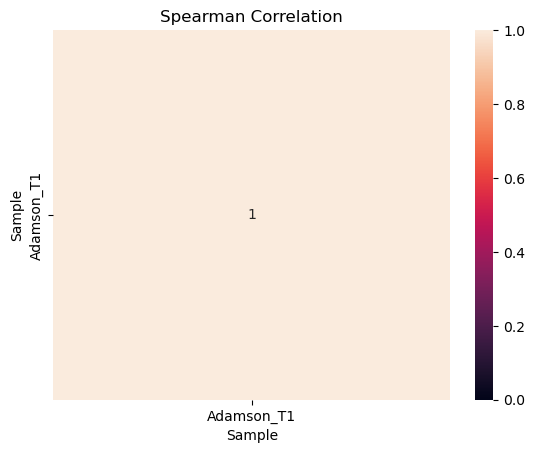

In [45]:
sns.heatmap(pd.DataFrame(results_df.xs("distances", level="Measure", axis=1).corr(method="spearman")), vmin=0, annot=True)
plt.title("Spearman Correlation")

Note that the Adamson dataset is 
1. More consistent in the genes that get ranked at the top
2. Produces more "outlying" genes

Both these could be caused by the higher resolution evident in the adamson dataset relative to the LUMC dataset. This would reduce the amount of noise and allow the signal to be much clearer.

# Cluster analysis


Across all datasets, do we see the same patterns across genes

In [46]:
df = pd.concat(X_imputed, axis=1)
df = df.loc[all_genes, :]
df.shape

(527, 7)

In [47]:
outliers

Dclre1c    0.000000
Mutyh      0.000000
Baz1b      0.000000
Brca1      0.000000
Brca2      0.000000
             ...   
Ino80b     0.000038
Pola2      0.000077
Top3a      0.000118
Ssbp1      0.000121
Smc3       0.000129
Length: 157, dtype: float64

(527, 7)
(157, 7)
(100, 7)
(157, 7)
(7,)
(157, 7)
Done.


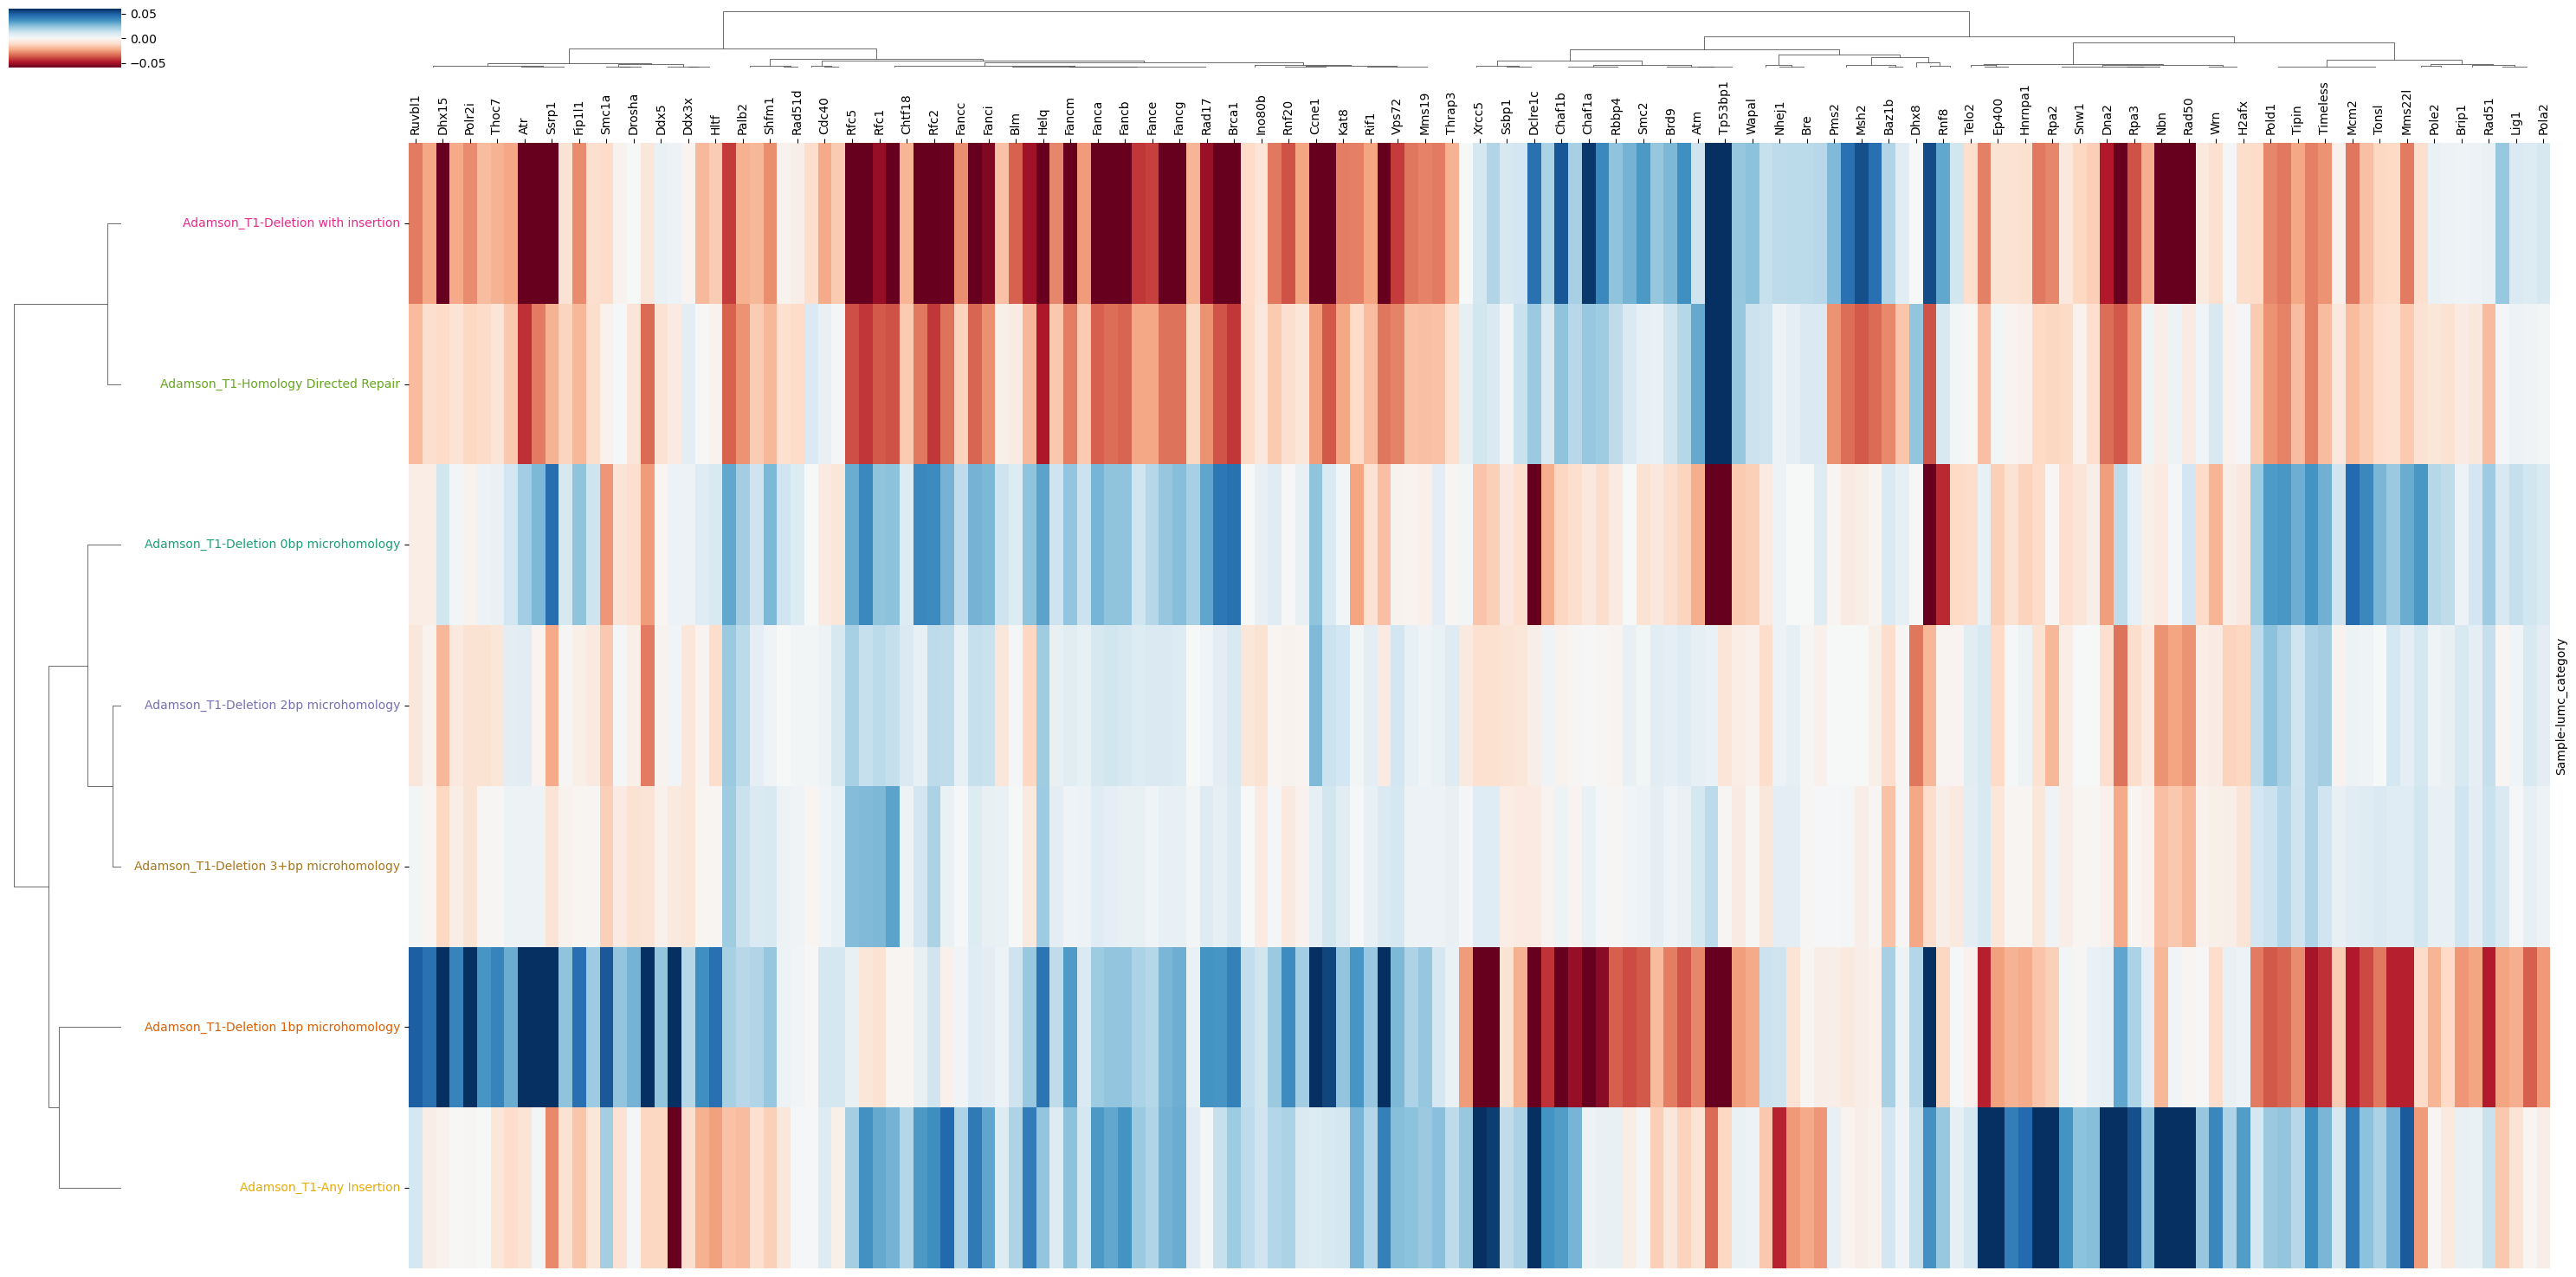

In [48]:
Xall = pd.concat(X_imputed, axis=0).dropna()
print(Xall.shape)

Xother = Xall.loc[Xall.index.get_level_values(level=1).isin(outliers.index)]
Xother.index.set_names("Sample", level=0, inplace=True)
print(Xother.shape)

Xpseudo = Xall.loc[Xall.index.get_level_values(level=1).isin(psuedo_controls)]
print(Xpseudo.shape)

Xpseudo_gmean = pd.DataFrame(Xpseudo.groupby(level=0, axis=0).apply(stats.gmean).values.tolist(), index=Xall.index.unique(0), columns=Xall.columns)
Xpseudo_gmean = Xpseudo_gmean.div(Xpseudo_gmean.sum(axis=1), axis=0)
Xpseudo_gmean

Xother = Xother.stack().reset_index().pivot(index="Gene", columns=["Sample", "lumc_category"], values=0).dropna()
print(Xother.shape)

Xpseudo_gmean = Xpseudo_gmean.stack()
print(Xpseudo_gmean.shape)

Xdiff = Xother - Xpseudo_gmean
print(Xdiff.shape)

# Xdiff.columns = ['{}_{}'.format(i, j) for i, j in Xdiff.columns]
Xdiff.index = Xdiff.index.to_list()

pal = sns.color_palette('Dark2', Xdiff.columns.get_level_values("lumc_category").unique().shape[0])
lut = dict(zip(Xdiff.columns.get_level_values("lumc_category").unique(), pal))
col_colors = Xdiff.columns.get_level_values("lumc_category").to_series().map(lut)

cg = sns.clustermap(Xdiff.T, metric="correlation", method="ward", figsize=(30, 15), center=0, dendrogram_ratio=(.05, .05), cmap="RdBu", vmax=0.06, vmin=-0.06, cbar_pos=(0, .9, .01, .1))
cg.ax_heatmap.yaxis.tick_left()
cg.ax_heatmap.xaxis.tick_top()

for i, tick_label in enumerate(cg.ax_heatmap.axes.get_yticklabels()):
    tick_text = tick_label.get_text().rsplit("-", 1)[1]
    tick_label.set_color(lut[tick_text])
    tick_label.set_rotation(0)

for i, tick_label in enumerate(cg.ax_heatmap.axes.get_xticklabels()):
    # tick_text = tick_label.get_text().rsplit("-", 1)[1]
    # tick_label.set_color(lut[tick_text])
    tick_label.set_rotation(90)
plt.tight_layout()
print("Done.")

(527, 7)
(100, 7)
(100, 7)
(100, 7)
(7,)
(100, 7)
Done.


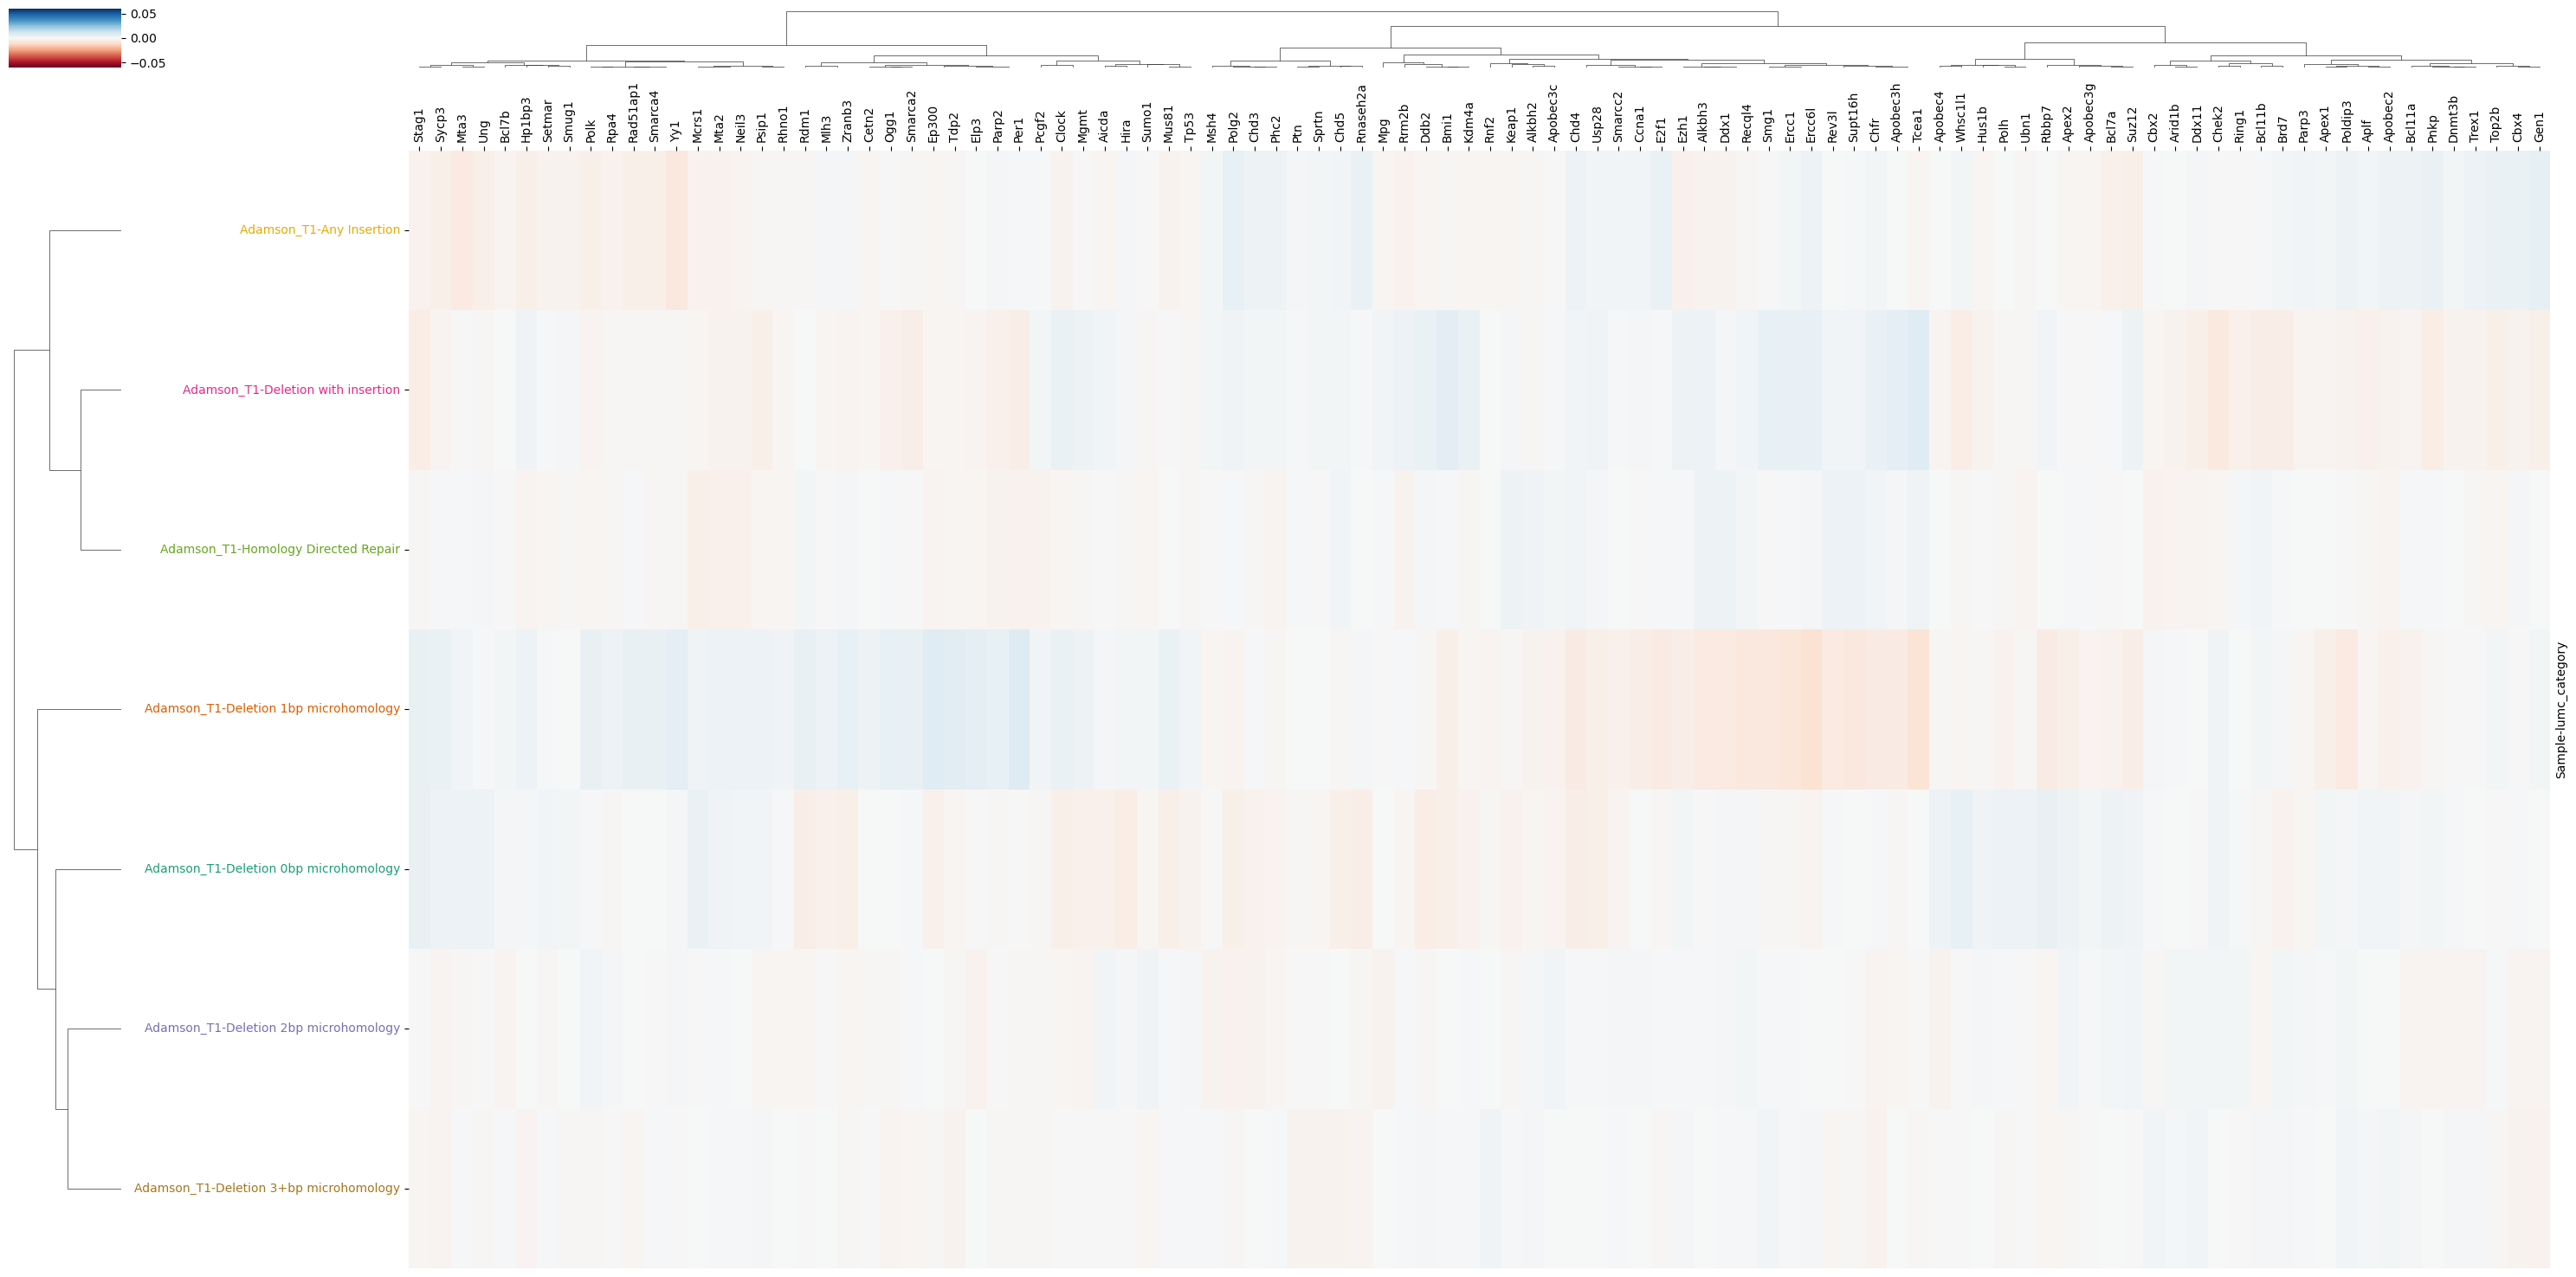

In [49]:
Xall = pd.concat(X_imputed, axis=0).dropna()
print(Xall.shape)

Xother = Xall.loc[Xall.index.get_level_values(level=1).isin(psuedo_controls)]
Xother.index.set_names("Sample", level=0, inplace=True)
print(Xother.shape)

Xpseudo = Xall.loc[Xall.index.get_level_values(level=1).isin(psuedo_controls)]
print(Xpseudo.shape)

Xpseudo_gmean = pd.DataFrame(Xpseudo.groupby(level=0, axis=0).apply(stats.gmean).values.tolist(), index=Xall.index.unique(0), columns=Xall.columns)
Xpseudo_gmean = Xpseudo_gmean.div(Xpseudo_gmean.sum(axis=1), axis=0)
Xpseudo_gmean

Xother = Xother.stack().reset_index().pivot(index="Gene", columns=["Sample", "lumc_category"], values=0).dropna()
print(Xother.shape)

Xpseudo_gmean = Xpseudo_gmean.stack()
print(Xpseudo_gmean.shape)

Xdiff = Xother - Xpseudo_gmean
print(Xdiff.shape)

# Xdiff.columns = ['{}_{}'.format(i, j) for i, j in Xdiff.columns]
Xdiff.index = Xdiff.index.to_list()

pal = sns.color_palette('Dark2', Xdiff.columns.get_level_values("lumc_category").unique().shape[0])
lut = dict(zip(Xdiff.columns.get_level_values("lumc_category").unique(), pal))
col_colors = Xdiff.columns.get_level_values("lumc_category").to_series().map(lut)

cg = sns.clustermap(Xdiff.T, metric="correlation", method="ward", figsize=(30, 15), center=0, dendrogram_ratio=(.05, .05), cmap="RdBu", vmax=0.06, vmin=-0.06, cbar_pos=(0, .9, .01, .1))
cg.ax_heatmap.yaxis.tick_left()
cg.ax_heatmap.xaxis.tick_top()

for i, tick_label in enumerate(cg.ax_heatmap.axes.get_yticklabels()):
    tick_text = tick_label.get_text().rsplit("-", 1)[1]
    tick_label.set_color(lut[tick_text])
    tick_label.set_rotation(0)

for i, tick_label in enumerate(cg.ax_heatmap.axes.get_xticklabels()):
    # tick_text = tick_label.get_text().rsplit("-", 1)[1]
    # tick_label.set_color(lut[tick_text])
    tick_label.set_rotation(90)
plt.tight_layout()
print("Done.")